In [1]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os, sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [2]:
folder_path = os.getcwd()
dataset_path = folder_path + '/' + 'pepperfry_dataset'

In [3]:
def get_all_folders(root_path):
    return [ item for item in os.listdir(dataset_path) if os.path.isdir(os.path.join(root_path, item)) ]

In [4]:
all_paths = []
for folder in get_all_folders(dataset_path):
    total_path = os.path.join(dataset_path, folder, 'metadata.txt')
    all_paths.append(total_path)

In [5]:
#some constants for tokenization
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
ps = PorterStemmer()

In [6]:
#removing the stopwords, punctuations, splitting and tokenization
colors = []
for path in all_paths:
    with open(path, 'r+') as metadata_file:
        for line in metadata_file:
            word_list = line.split(':')
            word_list = [w.lower().strip() for w in word_list]
            key = word_list[0].lower().strip()
            stripped = [w.translate(table) for w in word_list[1:]]
            stripped = [w.lower().strip() for w in stripped if not w in stop_words]
            value = ' '.join(stripped)
            if(key == 'colour' or key == 'color'):
                colors.append(value)

In [7]:
#method used for correcting the mistakes -- HARDCODED since domain knowledge -- can be commented too
def correct_errors(all_cols):
    for i, col in enumerate(all_cols):
        if(col == 'vermount'):
            all_cols[i] = 'vermont'
#         all_cols[i] = (ps.stem(col))
        elif(col == 'blacks'):
            all_cols[i] = 'black'
    return all_cols

In [8]:
#final level of processing
colors = correct_errors(colors)
colors = list(set(colors))
for i, color in enumerate(colors):
    all_cols = [item.lower().strip() for item in color.split(' ') if not item == '']
    final_col = ' '.join(all_cols)
    colors[i] = final_col.lower().strip()

In [9]:
colors

['vermont',
 'wenge',
 'provincial teak',
 'white',
 'blue',
 'honey oak',
 'warm walnut',
 'multicolour',
 'dual tone',
 'brown',
 'yellow',
 'black',
 'natural wenge',
 'red',
 'denver oak',
 'distress',
 'painted multicolour',
 'warm chestnut']

In [10]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [11]:
#Use vector addition of the constituent words of a phrase
#this typically works well because addition is a good estimation of semantic composition.
def combine_vectors(vectors):
    vectors = np.array(vectors).reshape(len(vectors), len(vectors[0]))
    vec = np.sum(vectors, axis = 0)
    return vec

In [12]:
def display_closestwords_tsnescatterplot(model, colors):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = []
    
    #for each word/phrase, add the corresponding vectors
    for word in colors:
        word_labels.append(word)
        all_vecs = []
        for ind_word in word.split(' '):
            all_vecs.append(model[ind_word])
        wrd_vector = combine_vectors(all_vecs)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

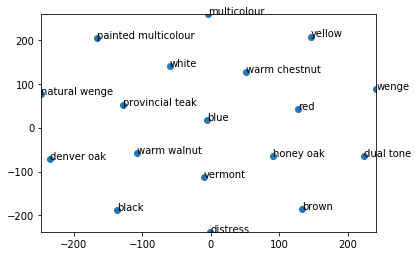

In [13]:
display_closestwords_tsnescatterplot(model, colors)